In [1]:
import numpy as np
import h5py
import time
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from py_files.basic_functions import getting_2D_data_from_h5_filtered_np_xy_switched_without_intensity_filter, getting_2D_data_from_h5_including_points_without_lasing

In [2]:
class layer: 
    main_name = 'Parameterentwicklung'
    h5_path = '/home/jan/Documents/IWU/Parameterentwicklung.h5'
    
    def __init__(self, number, part):
        self.number = number 
        self.part = part
        
    def array(self):
        return getting_2D_data_from_h5_filtered_np_xy_switched_without_intensity_filter(self.h5_path, self.main_name, self.part, 'Slice'+str("{:05}".format(self.number)))
    
    def array_wo_lasing(self):
        return getting_2D_data_from_h5_including_points_without_lasing(self.h5_path, self.main_name, self.part, 'Slice'+str("{:05}".format(self.number)))

In [3]:
def vector_dataframe(layer_number,  part_name,  ref_len,  diff_angle,  frequency):
    
    # inputs:
    # - layer_number (int)   - number of the layer of interest 
    # - part_name (str)      - name of the part of interest
    # - ref_len (float)      - reference length for deciding whether a vector is a jump or a write vector
    # - diff_angle (float)   - difference angle ''
    # - frequency (float)    - frequency of the monitoring system 
    
    # outputs:
    # - df_ref_points (pd.dataframe) - pandas dataframe containing all the relevant vectors 
    
    # initial values for the comparison (see block ...)
    sab_old = True
    len_crit_old = False
    
    
    # block 1: 
    
    print("start of block 1")
    layer_1 = layer(layer_number, part_name)
    array = layer_1.array_wo_lasing()
    
    zero_array = np.zeros((array.shape[0],13)) # adding zero columns to the data frame for the following calculations 
    new_array = np.append(array,zero_array,axis=1) # appending the zero array to the qmm array 
   
    # iterating through array
    # calculating the x and y difference of following points, the length and the angle of the connecting vector
   
    i = 1
    ref_len=13
    diff_angle=8
    ref_angle = 0
    sab_old = True
    len_crit_old = False

    # column naming: 
    # 0:x, 1:y, 2:int, 3:area, 4:next_x, 5:next_y, 6:x_diff, 7:y_diff, 8:length, 9:angle, 10:sab, 11:len_crit
    # 12:sab-1, 13:len_crit-1, 14:sab+1, 15:len_crit+1, 16:status


    for row in new_array:
        try:
            row[4] = new_array[i][0] # next x_value
            row[5] = new_array[i][1] # next y_value
            row[6] = row[4]-row[0] # x_diff
            row[7] = row[5]-row[1] # y_diff

            row[8] = np.sqrt(row[6]*row[6] + row[7]*row[7])  # length
            row[9] = 180/np.pi * np.arctan(row[7]/row[6])    # angle


            sab = (row[9] < (ref_angle+diff_angle) and row[9] > (ref_angle - diff_angle)) # sab and len_crit as bool
            len_crit = row[8] > ref_len

            if sab == True:        # check necessary, because Bool values can't be saved in a numpy ndarray
                row[10] = 1
            if len_crit == True:
                row[11] = 1
            if sab_old == True:
                row[12] = 1
            if len_crit_old == True:
                row[13] = 1

            sab_old = sab
            len_crit_old = len_crit
            ref_angle = row[9]

            i += 1


        except: 
            #print("problem occured at iteration number " + str(i-1))
            continue
    
    
    i = 1 # i is reset for the next iteration round 
    
   
    for row in new_array:
        try:
            
            # filling the columns of sab+1 and len_crit+1
            row[14] = new_array[i][10] # next sab value
            row[15] = new_array[i][11] # next len_crit_value 

            # performing the checks to decide the status of a certain vector 
            # resetting the values before every iteration -> default is false 
            sab = False
            length = False
            sab_p = False
            length_p = False
            sab_m = False
            length_m = False


            if row[10] == 1.:
                sab = True
            if row[11] == 1.:
                length = True
            if row[14] == 1.:
                sab_p = True
            if row[15] == 1.:
                length_p = True
            if row[12] == 1.:
                sab_m = True
            if row[13] == 1.:
                length_m = True

            # for a description of the different cases see truth table in scratchbook from Jan 
            if(
               (sab == 0 and length == 0 and sab_m == 0 and length_m == 0 and sab_p == 1 and length_p ==0) or
               (sab == 0 and length == 0 and sab_m == 0 and length_m == 1 and sab_p == 1 and length_p ==0) or
               #(sab == 0 and length == 0 and sab_m == 1 and length_m == 0 and sab_p == 1 and length_p ==0) or
               (sab == 0 and length == 0 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p ==0) or 
               (sab == 0 and length == 0 and sab_m == 1 and length_m == 1 and sab_p == 1 and length_p ==0)):

                status = 1 #"scan"

            elif((sab == 0 and length == 0 and sab_m == 0 and length_m == 1 and sab_p == 0 and length_p ==0) or
               (sab == 0 and length == 0 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 0 and length_m == 0 and sab_p == 0 and length_p == 0) or
               (sab == 0 and length == 1 and sab_m == 0 and length_m == 1 and sab_p == 0 and length_p == 0) or
               (sab == 0 and length == 1 and sab_m == 0 and length_m == 1 and sab_p == 1 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 1 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 1 and length_m == 1 and sab_p == 0 and length_p == 1) or
               (sab == 0 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 0 and length_p == 0)
                or (sab == 1 and length == 1 and sab_m == 1 and length_m == 0 and sab_p == 1 and length_p == 1)):

                
                status = 2 #"jump"

            else:
                status = 0 #"nd"

            row[16] = status  
 

            i += 1

        except:
            #print("problem occured at iteration number " + str(i-1))
            continue
            
            
    # transforming the array to a pandas dataframe         
    df = pd.DataFrame(data=new_array, columns=["x", "y","int","area", "x_next", "y_next", "x_diff", "y_diff", "length", "angle", "sab", "len_crit",
        "sab-1", "len_crit-1", "sab+1", "len_crit+1", "status"] )
    
    # block 5: the Scan and Jump vectors are extracted from the big dataframe
    
    df_ref_points = df[(df['status'] != 0)]
    df_ref_points = df_ref_points.reset_index()
    
        
    # block 6: New values for the length and angle columns are calculated for the small dataframe 
    
    for index,row in tqdm(df_ref_points.iterrows()):
        if index < (len(df_ref_points)-1):
            x_diff = df_ref_points['x'][index+1] - df_ref_points['x'][index]
            y_diff = df_ref_points['y'][index+1] - df_ref_points['y'][index]
            length = np.sqrt(x_diff*x_diff + y_diff*y_diff)
            angle = 180/np.pi * np.arctan(y_diff/x_diff)

            df_ref_points['x_diff'][index] = x_diff
            df_ref_points['y_diff'][index]= y_diff
            df_ref_points['length'][index] = length
            df_ref_points['angle'][index]  = angle  
                  
    # block 7: based on the frequency of the monitoring system and the distances scanning speeds are calculated and added 
    
    for index,row in tqdm(df_ref_points.iterrows()):

        try:
            time = (df_ref_points["number"][index+1] - df_ref_points["number"][index])*frequency # in seconds
            length = df_ref_points["length"][index]* (1/0.252) * 0.001 # (1/0.252 für transforming the Bit in µm amd 0.001 für tranforming µm to mm ) 

            speed = int(length/time) # in mm/s

            df_ref_points["speed"][index] = speed
            
        except:
            continue
                        
    return df, df_ref_points

In [4]:
# Ziel: alle Teile aus HDF5 bekommen

h5_path = '/home/jan/Documents/IWU/Parameterentwicklung.h5'

with h5py.File(h5_path, 'r') as h5:
    name_list = list(h5['Parameterentwicklung'].keys()) 
    print(name_list)

['W60_H100', 'W60_H101', 'W60_H102', 'W60_H103', 'W60_H104', 'W60_H105', 'W60_H106', 'W60_H107', 'W60_H108', 'W60_H109', 'W60_H110', 'W60_H111', 'W60_H112', 'W60_H113', 'W60_H114', 'W60_H115', 'W60_H116', 'W60_H117', 'W60_H118', 'W60_H119', 'W60_H120', 'W60_H121', 'W60_H122', 'W60_H123', 'W60_H124', 'W60_H125', 'W60_H126', 'W60_H127', 'W60_H128', 'W60_H129', 'W60_H130', 'W60_H131', 'W60_H132', 'W60_H133', 'W60_H134', 'W60_H135', 'W60_H136', 'W60_H137', 'W60_H138', 'W60_H139', 'W60_H140', 'W60_H141', 'W60_H142', 'W60_H143', 'W60_H144', 'W60_H145', 'W60_H146', 'W60_H147', 'W60_H148', 'W60_H149', 'W60_H150', 'W60_H151', 'W60_H152', 'W60_H153', 'W60_H154', 'W60_H155', 'W60_H156', 'W60_H157', 'W60_H158', 'W60_H159', 'W60_H160', 'W60_H161', 'W60_H162', 'W60_H163', 'W60_H164', 'W60_H165']


In [5]:
df, df_ref_points = vector_dataframe(4,  part_name="W60_H104",  ref_len=13,  diff_angle=8,  frequency=(1/40000))

start of block 1


/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars
0it [00:00, ?it/s]/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jan/anaconda3/envs/DataPrep/lib/python3.7/site-packages/ipykernel_launcher.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

In [12]:
df[27700:]

,x,y,int,area,x_next,y_next,x_diff,y_diff,length,angle,sab,len_crit,sab-1,len_crit-1,sab+1,len_crit+1,status
27700,5275.0,-3188.0,0.0,0.0,6430.0,-2033.0,1155.0,1155.0,1633.416665,45.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0
27701,6430.0,-2033.0,0.0,769.0,6500.0,-2001.0,70.0,32.0,76.967526,24.567171,0.0,1.0,0.0,1.0,0.0,1.0,0.0
27702,6500.0,-2001.0,0.0,0.0,5287.0,-3213.0,-1213.0,-1212.0,1714.734090,44.976373,0.0,1.0,0.0,1.0,0.0,1.0,0.0
27703,5287.0,-3213.0,0.0,808.0,5299.0,-3238.0,12.0,-25.0,27.730849,-64.358994,0.0,1.0,0.0,1.0,0.0,1.0,0.0
27704,5299.0,-3238.0,0.0,0.0,6569.0,-1968.0,1270.0,1270.0,1796.051224,45.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27903,8241.0,-3969.0,0.0,778.0,8311.0,-3937.0,70.0,32.0,76.967526,24.567171,0.0,1.0,0.0,1.0,0.0,1.0,0.0
27904,8311.0,-3937.0,0.0,0.0,8375.0,-3872.0,64.0,65.0,91.219515,45.444144,0.0,1.0,0.0,1.0,0.0,1.0,0.0
27905,8375.0,-3872.0,0.0,759.0,8387.0,-3898.0,12.0,-26.0,28.635642,-65.224859,0.0,1.0,0.0,1.0,0.0,0.0,2.0
27906,8387.0,-3898.0,0.0,0.0,8380.0,-3904.0,-7.0,-6.0,9.219544,40.601295,0.0,0.0,0.0,1.0,0.0,0.0,2.0


In [176]:
df.shape

(27908, 17)

In [7]:
df_ref_points[df_ref_points.sab == 1.]

,index,x,y,int,area,x_next,y_next,x_diff,y_diff,length,angle,sab,len_crit,sab-1,len_crit-1,sab+1,len_crit+1,status
50,1723,6284.0,-2106.0,0.0,733.0,6311.0,-2089.0,69.0,33.0,76.485293,25.559965,1.0,1.0,1.0,0.0,1.0,1.0,2.0


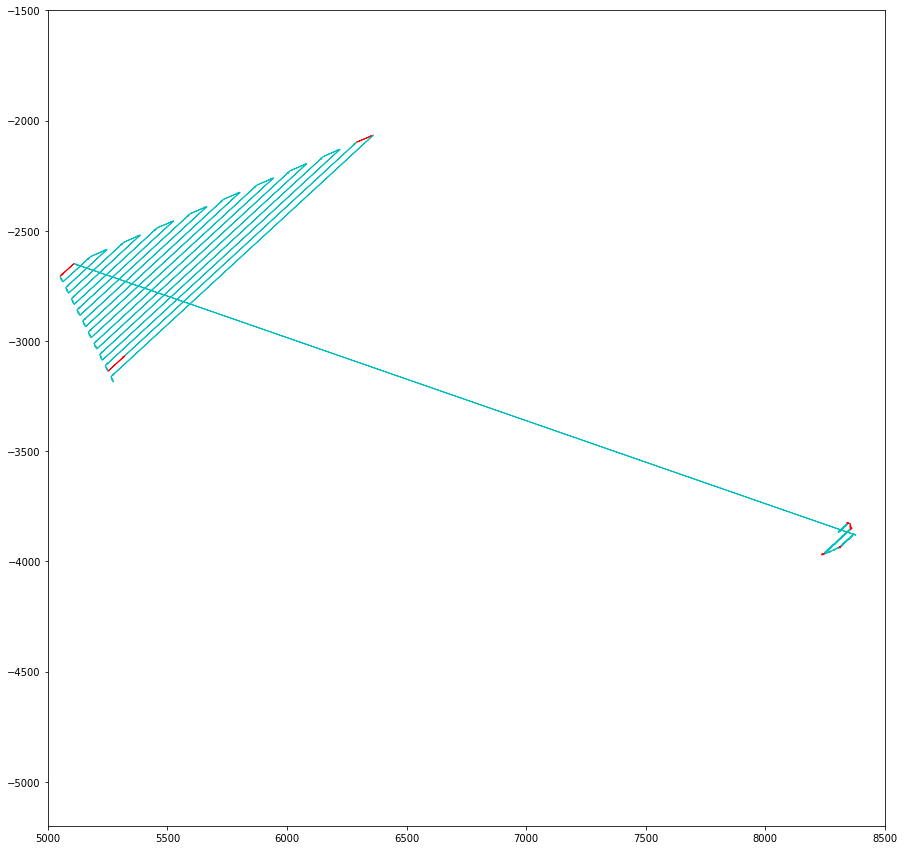

In [11]:
fig, ax = plt.subplots(figsize=(15,15))

start = 27620
end = 27700

for i in range(start, end):    #(len(df_turn)):   
    x_pos = df['x'][i]
    y_pos = df['y'][i]
    x_direct = df['x_diff'][i]
    y_direct = df['y_diff'][i]
    if df['status'][i] == 0:
        color = 'c'
    else: 
        color = 'r'
    
    ax.arrow(x_pos,y_pos,x_direct,y_direct, head_width= 5, head_length= 15, fc='r', ec=color,length_includes_head = True)
    ax.axis([5000, 8500, -5200, -1500])
   
    
    #ax.scatter(x_pos,y_pos, s = 10)   
        
plt.show()

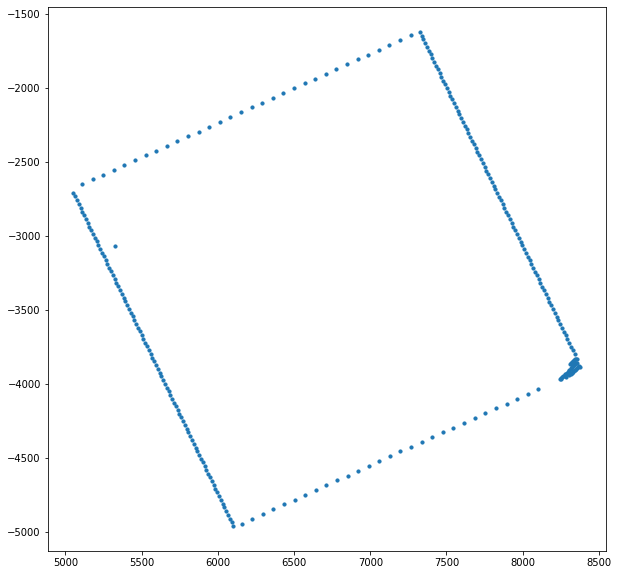

In [183]:
# plots for identifying the error points
start = 27620
end = 27900

fig, ax = plt.subplots(figsize=(10,10))
 
x_pos = df['x'][start:end]
y_pos = df['y'][start:end]
n = [int(i) for i in df.index][start:end]

ax.scatter(x_pos, y_pos, s = 10)

   
#for i, txt in enumerate(n):
#        ax.annotate(txt, (x_pos[i+start], y_pos[i+start]))

plt.show()

In [184]:
df[27620:]

,x,y,int,area,x_next,y_next,x_diff,y_diff,length,angle,sab,len_crit,sab-1,len_crit-1,sab+1,len_crit+1,status
27620,8309.0,-3864.0,0.0,798.0,8317.0,-3857.0,8.0,7.0,10.630146,41.185925,1.0,0.0,1.0,0.0,1.0,0.0,0.0
27621,8317.0,-3857.0,0.0,783.0,8322.0,-3852.0,5.0,5.0,7.071068,45.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0
27622,8322.0,-3852.0,0.0,774.0,8329.0,-3844.0,7.0,8.0,10.630146,48.814075,1.0,0.0,1.0,0.0,1.0,0.0,0.0
27623,8329.0,-3844.0,0.0,764.0,8334.0,-3839.0,5.0,5.0,7.071068,45.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0
27624,8334.0,-3839.0,0.0,811.0,8342.0,-3832.0,8.0,7.0,10.630146,41.185925,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27903,8241.0,-3969.0,0.0,778.0,8311.0,-3937.0,70.0,32.0,76.967526,24.567171,0.0,1.0,0.0,1.0,0.0,1.0,0.0
27904,8311.0,-3937.0,0.0,0.0,8375.0,-3872.0,64.0,65.0,91.219515,45.444144,0.0,1.0,0.0,1.0,0.0,1.0,0.0
27905,8375.0,-3872.0,0.0,759.0,8387.0,-3898.0,12.0,-26.0,28.635642,-65.224859,0.0,1.0,0.0,1.0,0.0,0.0,2.0
27906,8387.0,-3898.0,0.0,0.0,8380.0,-3904.0,-7.0,-6.0,9.219544,40.601295,0.0,0.0,0.0,1.0,0.0,0.0,2.0


In [157]:
df_ref_points.shape

(347, 18)

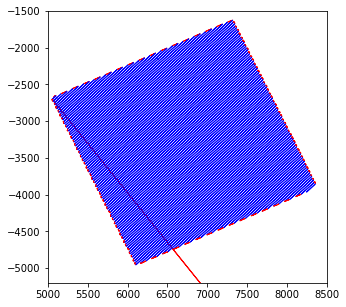

In [172]:
fig, ax = plt.subplots(figsize=(5,5))

for i in range(340):    #(len(df_turn)):   
    x_pos = df_ref_points['x'][i]
    y_pos = df_ref_points['y'][i]
    x_direct = df_ref_points['x_diff'][i]
    y_direct = df_ref_points['y_diff'][i]
    if df_ref_points['status'][i] == 1:
        color = 'b'
    else: 
        color = 'r'
    
    ax.arrow(x_pos,y_pos,x_direct,y_direct, head_width= 5, head_length= 15, fc='r', ec=color,length_includes_head = True)
    ax.axis([5000, 8500, -5200, -1500])
    
    
    #ax.scatter(x_pos,y_pos, s = 10)   
        
plt.show()

In [120]:
df_ref_points[40:60]

,index,x,y,int,area,x_next,y_next,x_diff,y_diff,length,angle,sab,len_crit,sab-1,len_crit-1,sab+1,len_crit+1,status
40,983,5207.0,-3034.0,0.0,0.0,5212.0,-3029.0,804.0,804.0,1137.027704,45.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0
41,1112,6011.0,-2230.0,0.0,710.0,6033.0,-2218.0,67.0,30.0,73.409809,24.120983,0.0,1.0,1.0,0.0,1.0,1.0,2.0
42,1115,6078.0,-2200.0,0.0,0.0,6070.0,-2208.0,-856.0,-856.0,1210.566809,45.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.0
43,1252,5222.0,-3056.0,0.0,751.0,5233.0,-3082.0,11.0,-26.0,28.231188,-67.067900,0.0,1.0,1.0,0.0,0.0,0.0,2.0
44,1253,5233.0,-3082.0,0.0,0.0,5241.0,-3074.0,912.0,912.0,1289.762769,45.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0
45,1399,6145.0,-2170.0,0.0,735.0,6172.0,-2154.0,69.0,32.0,76.059187,24.880367,0.0,1.0,1.0,0.0,1.0,1.0,2.0
46,1402,6214.0,-2138.0,0.0,0.0,6209.0,-2143.0,-966.0,-966.0,1366.130301,45.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0
47,1557,5248.0,-3104.0,0.0,786.0,5248.0,-3129.0,0.0,-25.0,25.000000,-90.000000,0.0,1.0,1.0,0.0,0.0,0.0,2.0
48,1558,5248.0,-3129.0,0.0,0.0,5257.0,-3132.0,9.0,-3.0,9.486833,-18.434949,0.0,0.0,0.0,1.0,0.0,0.0,2.0
49,1559,5257.0,-3132.0,0.0,0.0,5262.0,-3127.0,62.0,62.0,87.681241,45.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0
